In [163]:
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers # type: ignore
from tensorflow.keras import models # type: ignore
from IPython import display
tf.keras.layers

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [164]:
DATASET_PATH = 'train/audio'
data_dir = pathlib.Path(DATASET_PATH)

TEST_PATH = 'test'
test_dir = pathlib.Path(TEST_PATH)

In [165]:
words = np.array(tf.io.gfile.listdir(str(data_dir)))
words = np.delete(words, np.where(words == '_background_noise_'))
print('Commands:', words)

Commands: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [166]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

orig_label_names = np.array(train_ds.class_names)
print()
print("label names:", orig_label_names)

Found 64721 files belonging to 30 classes.
Using 51777 files for training.
Using 12944 files for validation.

label names: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [167]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=64,
    shuffle=False,
    class_names=None,
    output_sequence_length=16000)


Found 158538 files belonging to 1 classes.


In [168]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [169]:
label_names = np.asarray(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown'])
label_names_map = {label: i for i, label in enumerate(label_names)}

In [170]:
label_names_map

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10}

In [171]:
# Function to map labels
def map_labels(labels):
    # 10 - unknown label
    return np.array([label_names_map.get(orig_label_names[label], 10) for label in labels], dtype=np.int64)

# Transform labels in train and validation datasets
def preprocess_dataset(dataset):
    def map_and_set_shape(x, y):
        # Apply mapping
        y = tf.numpy_function(map_labels, [y], tf.int64)
        # Explicitly set the shape of the labels to be scalar
        y.set_shape([None])  # [] means a scalar label
        return x, y

    return dataset.map(map_and_set_shape, num_parallel_calls=tf.data.AUTOTUNE)

In [172]:
train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

In [173]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [174]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)


In [175]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [176]:
label_names[[1,1,3,0]]

array(['no', 'no', 'down', 'yes'], dtype='<U7')

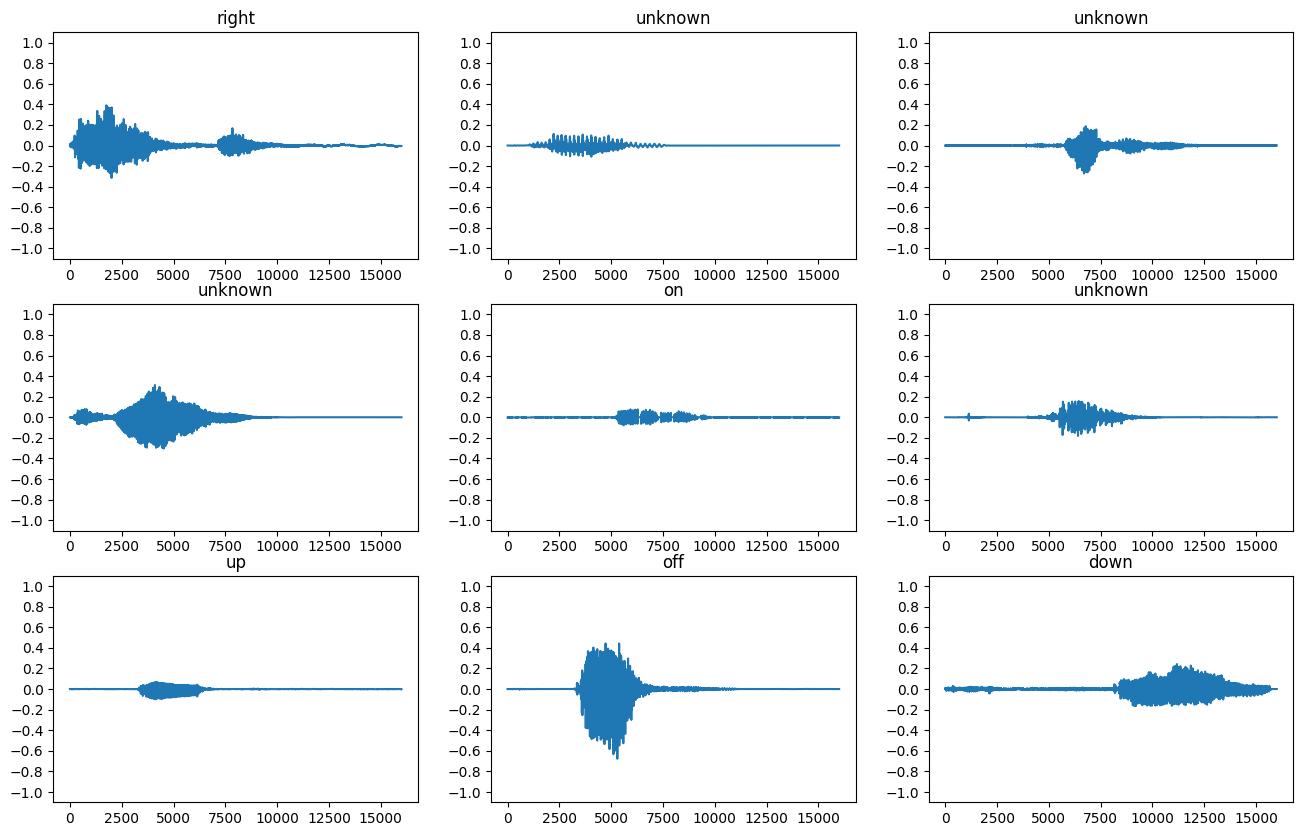

In [177]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [178]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [179]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [180]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

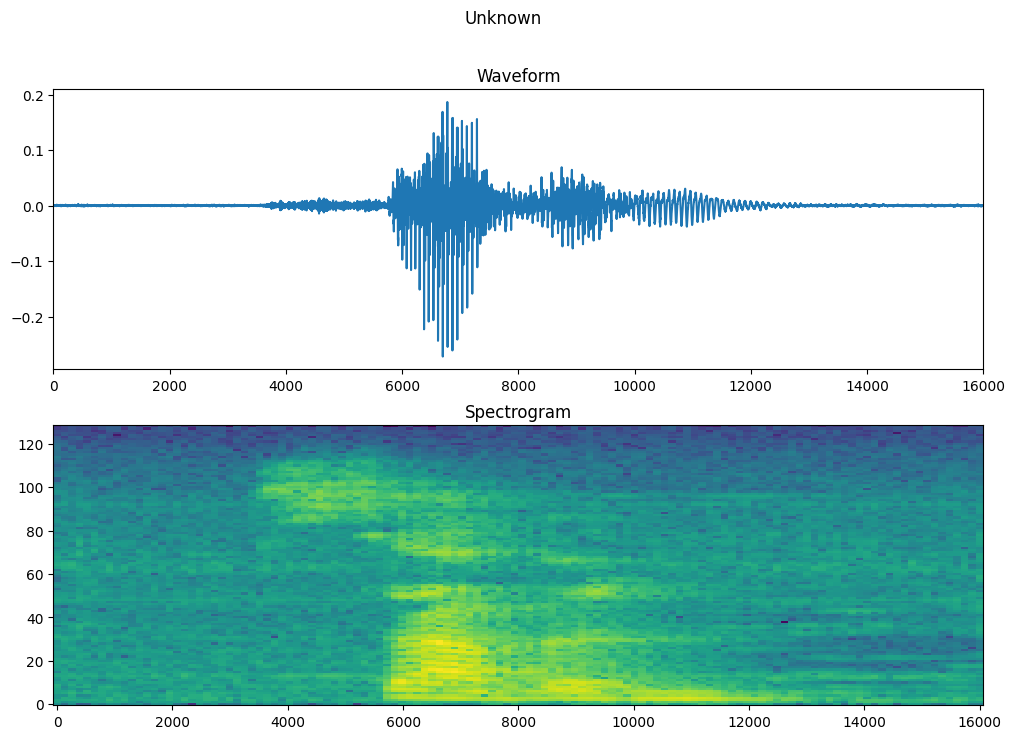

In [181]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [182]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [183]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [184]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

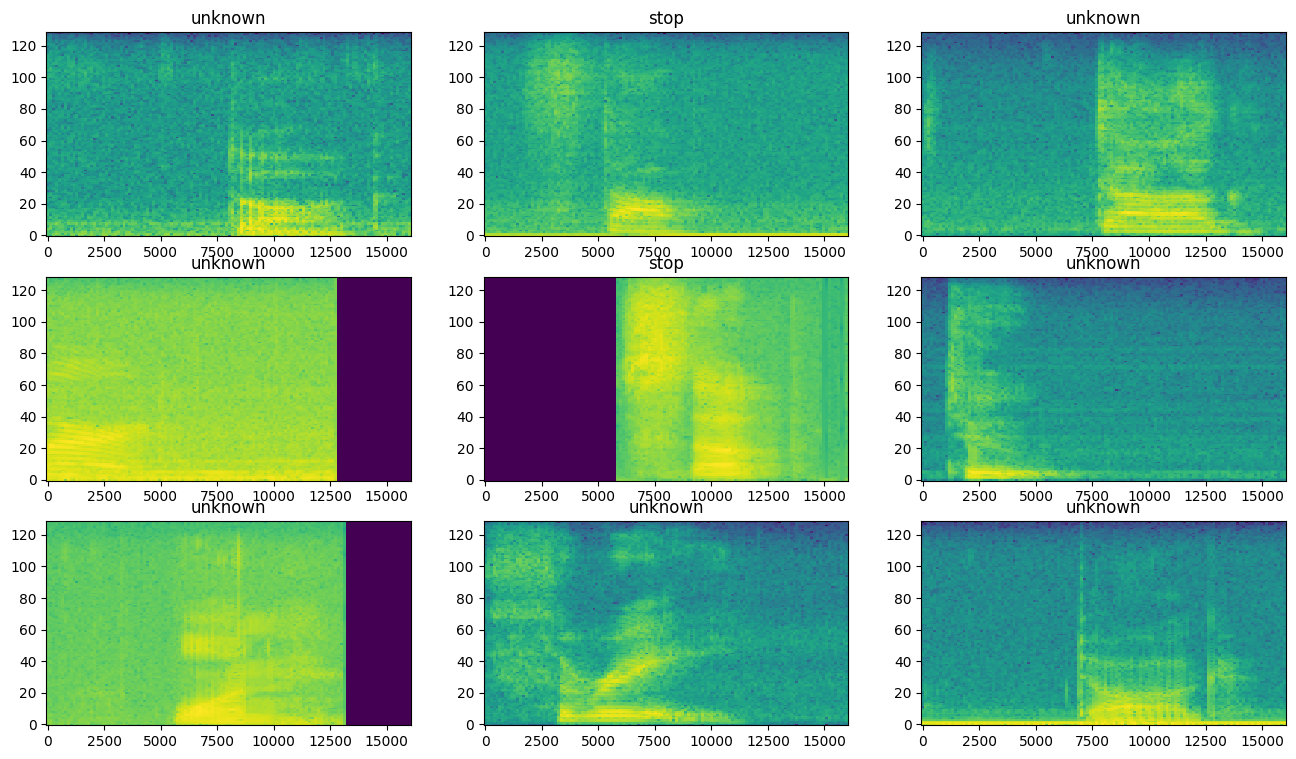

In [185]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [186]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [187]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,998 (6.20 MB)

 Trainable params: 1,625,995 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [188]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [189]:
train_spectrogram_ds.element_spec

(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [190]:
EPOCHS = 5

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.6403 - loss: 1.3366 - val_accuracy: 0.7720 - val_loss: 0.6729
Epoch 2/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7556 - loss: 0.7343 - val_accuracy: 0.8314 - val_loss: 0.4937
Epoch 3/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8044 - loss: 0.5860 - val_accuracy: 0.8629 - val_loss: 0.4160
Epoch 4/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8308 - loss: 0.5043 - val_accuracy: 0.8711 - val_loss: 0.3951
Epoch 5/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8504 - loss: 0.4475 - val_accuracy: 0.8830 - val_loss: 0.3653


Text(0, 0.5, 'Accuracy [%]')

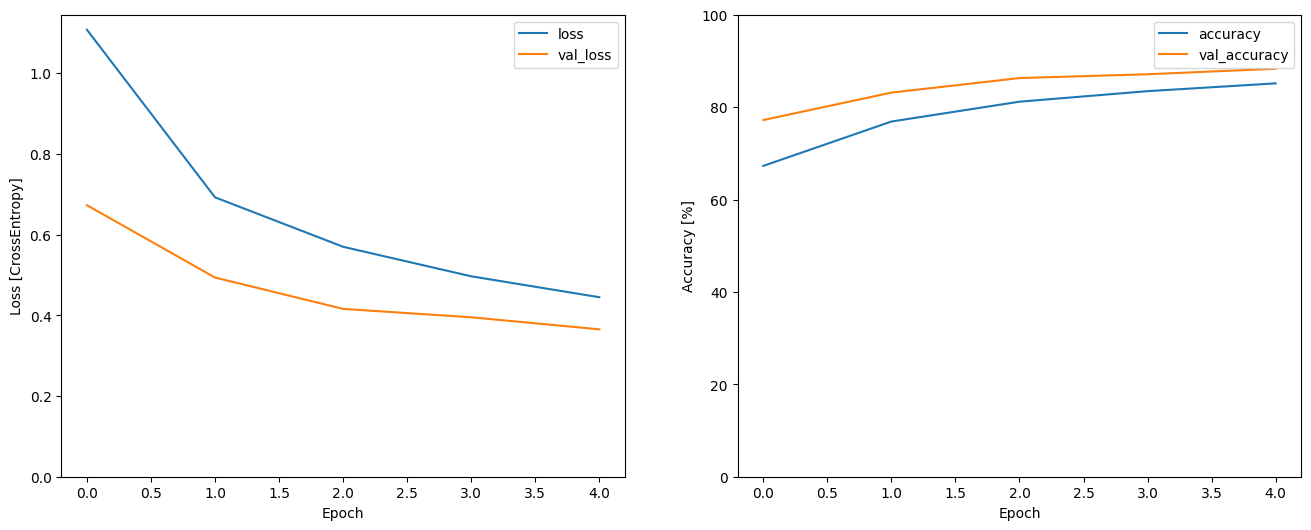

In [191]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [192]:
y_pred = model.predict(test_spectrogram_ds)

2478/2478 ━━━━━━━━━━━━━━━━━━━━ 113s 45ms/step


In [193]:
y_pred = tf.argmax(y_pred, axis=1)

In [194]:
y_pred

<tf.Tensor: shape=(158538,), dtype=int64, numpy=array([ 1, 10, 10, ..., 10, 10, 10], dtype=int64)>

In [195]:
label_mapping = {index: value for index, value in enumerate(label_names)}

label_texts = [label_mapping[label] for label in y_pred.numpy()]

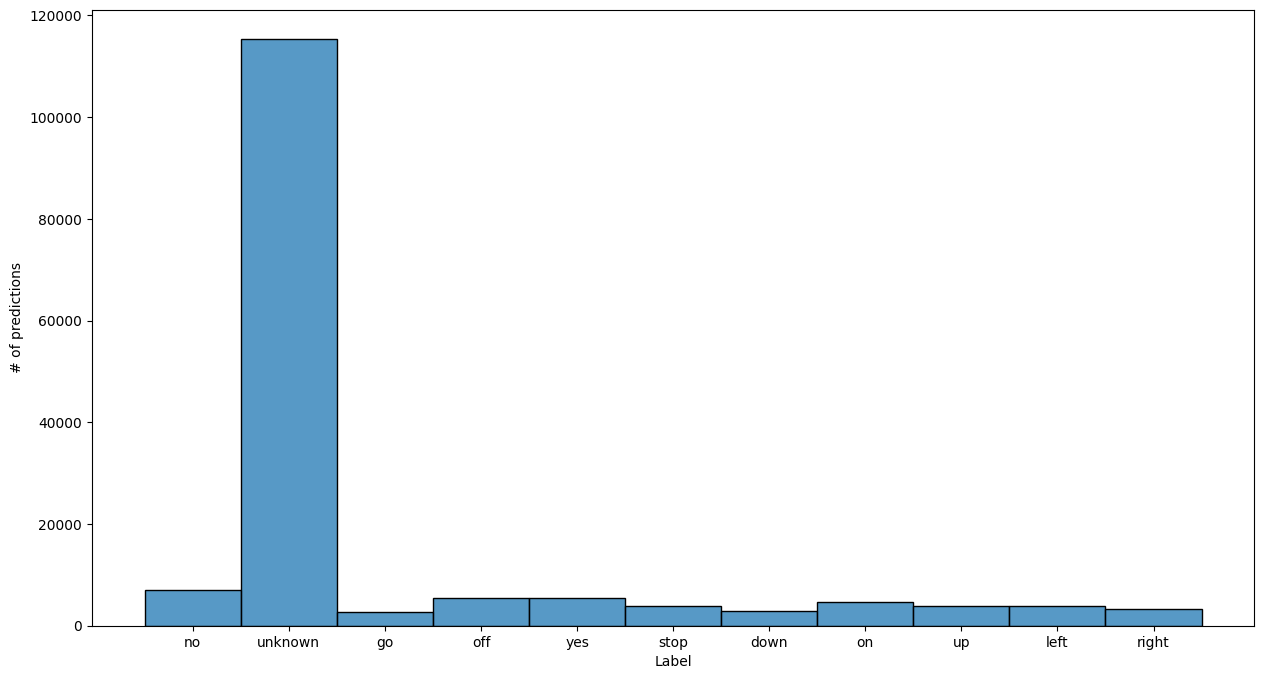

In [196]:

plt.figure(figsize=(15, 8))
sns.histplot(label_texts)
plt.xlabel('Label')
plt.ylabel('# of predictions')
plt.show()

In [197]:
result_df = pd.DataFrame(label_texts, columns=['label'])
result_df["file"] = [path.name for path in test_dir.glob("*/*")]
result_df = result_df[['file', 'label']]
result_df.to_csv('submission.csv', index=False)